In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os

In [3]:
# Define parameters
img_height, img_width = 224, 224
batch_size = 32
epochs = 20

In [4]:
# 1. Data Collection and Preprocessing
data_gen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load training and validation data
train_data = data_gen.flow_from_directory(
    directory=r"C:\Users\sucha\OneDrive\Desktop\Chest-CT-Scan-data",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_data = data_gen.flow_from_directory(
    directory=r"C:\Users\sucha\OneDrive\Desktop\Chest-CT-Scan-data",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)


Found 275 images belonging to 2 classes.
Found 68 images belonging to 2 classes.


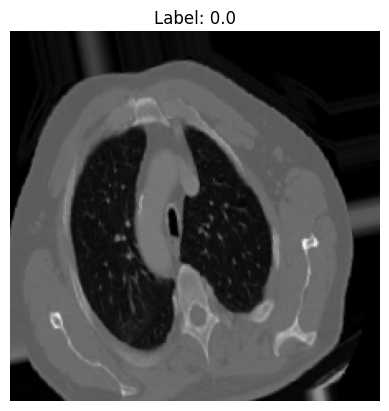

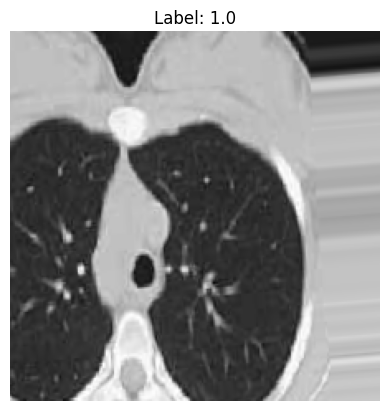

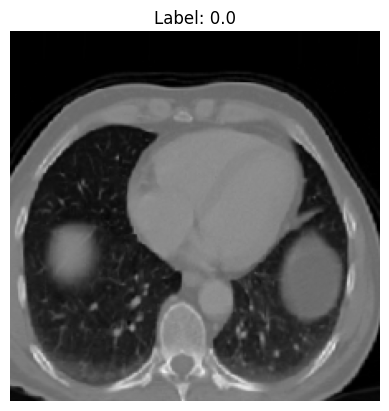

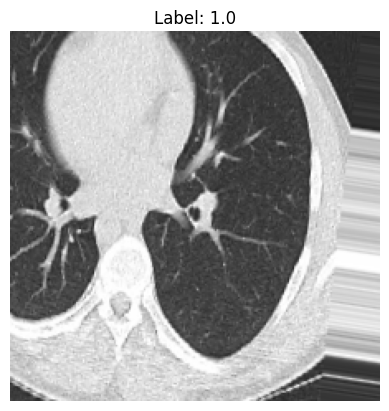

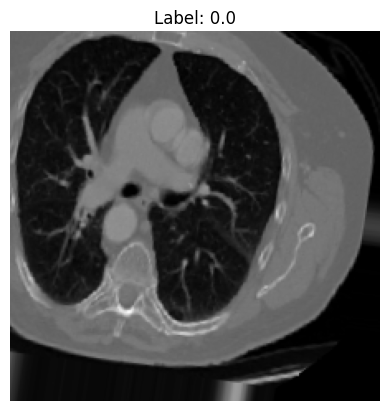

In [5]:
# 2. Data Visualization (Visualizing Sample Data)
def visualize_samples(dataset, num_samples=5):
    for i, (img, label) in enumerate(dataset):
        if i >= num_samples:
            break
        plt.imshow(img[0])  # Display the first image in each batch
        plt.title(f"Label: {label[0]}")
        plt.axis('off')
        plt.show()

# Visualize some samples from the training data
visualize_samples(train_data)

In [8]:
def build_ver_net(input_shape=(224, 224, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder (downsampling)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Decoder (upsampling)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)

    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)

    # Global Average Pooling to reduce spatial dimensions
    x = layers.GlobalAveragePooling2D()(x)

    # Output layer
    outputs = layers.Dense(1, activation='sigmoid')(x)  # Change to Dense layer

    model = models.Model(inputs, outputs)
    return model

In [9]:
# Instantiate the model
model = build_ver_net()

# 4. Model Compilation
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 5. Model Training
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs
)

Epoch 1/20
9/9 [==============================] - 19s 2s/step - loss: 0.6947 - accuracy: 0.4036 - val_loss: 0.6850 - val_accuracy: 0.4265
Epoch 2/20
9/9 [==============================] - 14s 2s/step - loss: 0.6555 - accuracy: 0.4364 - val_loss: 0.6088 - val_accuracy: 0.4412
Epoch 3/20
9/9 [==============================] - 14s 2s/step - loss: 0.5771 - accuracy: 0.5891 - val_loss: 0.5004 - val_accuracy: 0.7500
Epoch 4/20
9/9 [==============================] - 14s 2s/step - loss: 0.4973 - accuracy: 0.8327 - val_loss: 0.5595 - val_accuracy: 0.7500
Epoch 5/20
9/9 [==============================] - 14s 2s/step - loss: 0.4095 - accuracy: 0.8618 - val_loss: 0.3411 - val_accuracy: 0.8824
Epoch 6/20
9/9 [==============================] - 14s 2s/step - loss: 0.4462 - accuracy: 0.8364 - val_loss: 0.3356 - val_accuracy: 0.8824
Epoch 7/20
9/9 [==============================] - 14s 1s/step - loss: 0.3685 - accuracy: 0.8545 - val_loss: 0.3543 - val_accuracy: 0.8382
Epoch 8/20
9/9 [==================

In [10]:
# 6. Visualizing Training History
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(epochs)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend (loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

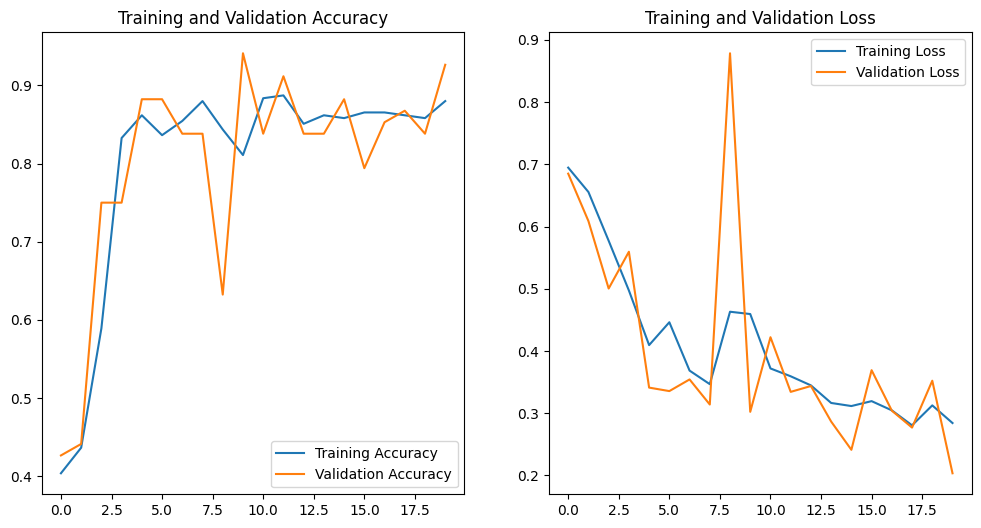

In [11]:
# Plot the training history
plot_history(history)

In [12]:
# 6. Model Evaluation
def evaluate_model(model, val_data):
    val_steps = val_data.samples // val_data.batch_size
    val_loss, val_accuracy = model.evaluate(val_data, steps=val_steps)
    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

evaluate_model(model, val_data)


2/2 [==============================] - 2s 566ms/step - loss: 0.2184 - accuracy: 0.9062
Validation Loss: 0.21840320527553558, Validation Accuracy: 0.90625


In [13]:
# 7. Hyperparameter Tuning (Example using Keras Tuner)
from kerastuner import HyperModel, RandomSearch

class MyHyperModel(HyperModel):
    def build(self, hp):
        model = build_ver_net()
        model.compile(
            optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model

C:\Users\sucha\AppData\Local\Temp\ipykernel_32704\1809708074.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel, RandomSearch


In [14]:
tuner = RandomSearch(
    MyHyperModel(),
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory = 'my_dir',
    project_name='chest_ct_tuning'
)

tuner.search(train_data, validation_data=val_data, epochs=epochs)


Trial 3 Complete [00h 04m 36s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 15m 00s


In [15]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]


In [16]:
print(best_model)

In [17]:
# 8. Saving the Model
model.save('chest_cancer_model.h5')

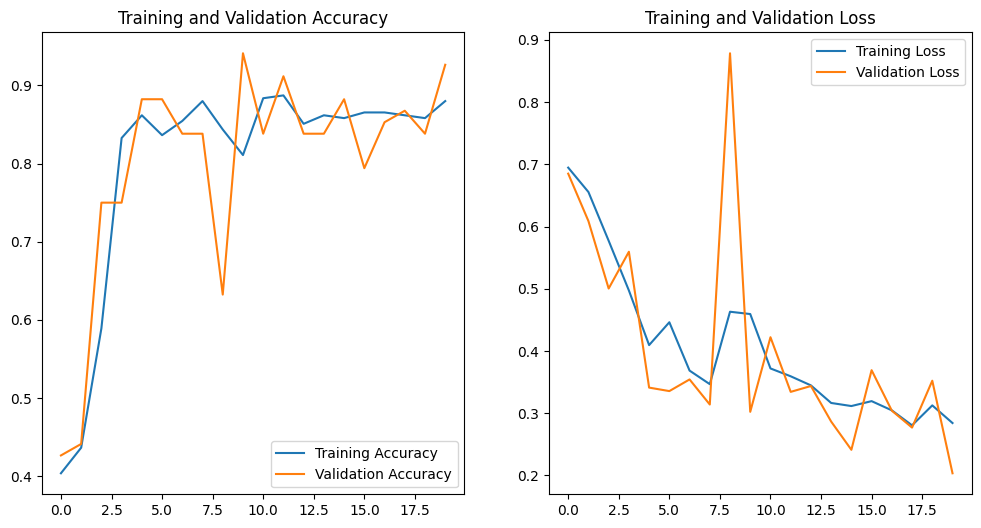

In [18]:
# 10. Plotting training & validation loss/accuracy
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(epochs)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Plot the training history
plot_history(history)